In [331]:
# autoreload
%reload_ext autoreload
%autoreload 2

## Cleaning coordinates
Create a new column in the df with the 'gold standard' coordinates. These are coordinates in decimal degree format. Save as a csv for export to GEE. Sense-check each point, refine, and transfer final files (as csv and yaml) to Ben H. 

Where coordinates are explicitly available in papers, use these. Where not available, take 'location' and search for coordinates using Google Maps API. 

In [332]:
### imports
# general
import pandas as pd
import re
import googlemaps
from tqdm.auto import tqdm

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# custom
from calcification import locations, config, locations, utils

In [333]:
### load data
fp = config.data_dir / "Orlando_data.xlsx"
df = utils.process_df(pd.read_excel(fp, sheet_name="all_data"))

# create column and fill with cleaned coordinates, where 
df['loc'] = df['cleaned_coords'].fillna(df['location'])
# df['loc'].value_counts()


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0', '10.1007/s00227-012-2001-y']
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.


In [352]:
df

,extractor,notes,secondary_check,include,authors,doi,year,species_types,taxa,location,...,species,family,functional_group,core_grouping,st_calcification_unit,st_calcification,st_calcification_sd,loc,latitude,longitude
0,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,2023-01-01,Porolithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,onkodes,Porolithaceae,Crustose coralline algae,CCA,gCaCO3 cm-2d-1,0.001971,0.000571,"(-14.692277777777779, 145.45923611111112)",-14.692278,145.459236
1,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,2023-01-01,Porolithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,onkodes,Porolithaceae,Crustose coralline algae,CCA,gCaCO3 cm-2d-1,0.002409,0.000424,"(-14.692277777777779, 145.45923611111112)",-14.692278,145.459236
2,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,2023-01-01,Porolithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,onkodes,Porolithaceae,Crustose coralline algae,CCA,gCaCO3 cm-2d-1,0.001664,0.000375,"(-14.692277777777779, 145.45923611111112)",-14.692278,145.459236
3,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,2023-01-01,Porolithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,onkodes,Porolithaceae,Crustose coralline algae,CCA,gCaCO3 cm-2d-1,0.001839,0.000277,"(-14.692277777777779, 145.45923611111112)",-14.692278,145.459236
4,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,2023-01-01,Lithophyllum cf insipidum,Algae,"Lizard Island, GBR, Australia",...,insipidum,Lithophyllaceae,Crustose coralline algae,CCA,gCaCO3 cm-2d-1,0.001468,0.000294,"(-14.692277777777779, 145.45923611111112)",-14.692278,145.459236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6988,Cornwall,NaN,0,yes,Vasquez-Elizondo and Enriquez,10.1038/srep19030,2016-01-01,Neogoniolithon sp.,CCA,"reef lagoon, Puerto Morelos, Mexico, Caribbean",...,spp,Spongitidaceae,Crustose coralline algae,CCA,,,,"(20.85, -86.91666666666667)",20.850000,-86.916667
6989,Cornwall,NaN,0,yes,Venn et al. 2013,10.1073/pnas.0902894106,2009-01-01,Stylophora pistillata,Coral,"Aquarium, Mediterranean",...,pistillata,Pocilloporidae,Hard coral,Coral,,,,"(None, None)",NaN,NaN
6990,Cornwall,NaN,0,yes,Venn et al. 2013,10.1073/pnas.0902894106,2009-01-01,Stylophora pistillata,Coral,"Aquarium, Mediterranean",...,pistillata,Pocilloporidae,Hard coral,Coral,,,,"(None, None)",NaN,NaN
6991,Cornwall,NaN,0,yes,Venn et al. 2013,10.1073/pnas.0902894106,2009-01-01,Stylophora pistillata,Coral,"Aquarium, Mediterranean",...,pistillata,Pocilloporidae,Hard coral,Coral,,,,"(None, None)",NaN,NaN


In [334]:
### get locations for which there are no coordinates (from location, where cleaned_coords is NaN)
locs = df.loc[df['cleaned_coords'].isna(), 'location'].unique()
# get coordinates for these locations using Google Maps API
gmaps_coords = {}
GMAPS_API_KEY = utils.read_yaml(config.resources_dir / "api_keys.yaml")['google_maps_api']
gmaps_client = googlemaps.Client(key=GMAPS_API_KEY)

for loc in tqdm(locs, desc="Querying Google Maps to retrieve coordinates of locations"):
    gmaps_coords[loc] = tuple(locations.get_coordinates_from_gmaps(loc, gmaps_client).values)   # slightly hacky formatting since originally written for processing dataframe column
gmaps_coords

Querying Google Maps to retrieve coordinates of locations: 100%|██████████| 94/94 [00:07<00:00, 12.57it/s]


{'Palmyra Atoll': (np.float64(5.8885026), np.float64(-162.0786656)),
 'Fiji, UK aquarium': (np.float64(55.378051), np.float64(-3.435973)),
 'Aquarium': (None, None),
 'Island Point, Panama': (np.float64(8.537981), np.float64(-80.782127)),
 "Mo'orea, French Polynesia": (np.float64(-17.5388435),
  np.float64(-149.8295234)),
 'Gulf of Aqaba, Jordan': (np.float64(28.6929261), np.float64(34.7298765)),
 'Ikei Island, Uruma, Okinawa, Japan': (np.float64(26.393366),
  np.float64(127.9969928)),
 'Hawaii, various': (np.float64(19.8986819), np.float64(-155.6658568)),
 'Oku Reef, Okinawa, Japan': (np.float64(26.8271449), np.float64(128.2796738)),
 'Indo-Pacific': (None, None),
 'Florida Keys National Marine Sanctuary': (np.float64(24.4269857),
  np.float64(-83.11127979999999)),
 'Gulf of Aqaba-Eilat, Israel': (np.float64(29.557669), np.float64(34.951925)),
 'Summerland Key, Florida, USA': (np.float64(24.6613356),
  np.float64(-81.4448502)),
 'M': (None, None),
 'Luhuitou fringing reef, South China

In [335]:
unique_coords = df['cleaned_coords'].unique()

failed_coords = []
for coord in unique_coords:
    standardised_coord = locations.standardize_coordinates(coord)
    if not standardised_coord:
        failed_coords.append(coord)
    else:
        print('OG:', coord, 'Standardised:', standardised_coord)

OG: 14°41′17.4′′S, 145°28′03.6′′E / 14°41′47.0′′S, 145°27′02.9′′E Standardised: (np.float64(-14.692277777777779), np.float64(145.45923611111112))
OG: 17°28′40.51′′S, 149°50′22.80′′W Standardised: (-17.477919444444442, -149.8396666666667)
OG: 25.02° N, 80.49° W Standardised: (25.02, -80.49)
OG: 26°19.62’N, 80°04.33’W Standardised: (26.327, -80.07216666666666)
OG: nan Standardised: nan
OG: 17.05°N 111.30°E Standardised: (17.05, 111.3)
OG: 23°26′S 151°52′E Standardised: (-23.433333333333334, 151.86666666666667)
OG: 18°12′N, 109°28′E Standardised: (18.2, 109.46666666666667)
OG: 9.3326, -82.2164 Standardised: (9.3326, -82.2164)
OG: 9.22025, -82.3231 Standardised: (9.22025, -82.3231)
OG: 23 33’S, 151 54’E Standardised: (-23.55, 151.9)
OG: 18° 41.126′S, 146° 30.731′E Standardised: (-18.685433333333332, 146.51218333333333)
OG: 24.62055° N, 81.37078° W Standardised: (24.62055, -81.37078)
OG: 21.955°N, 120.766°E / 21.931°N, 120.745°E Standardised: (np.float64(21.942999999999998), np.float64(120.

In [336]:
# fill loc with standardised cleaned_coords if not NaN, otherwise fill with coordinates extracted from location
# df['loc'] = df['cleaned_coords'].apply(lambda x: utils.standardize_coordinates(x) if pd.notna(x) else None).fillna(df['location'].map(gmaps_coords))
df['loc'] = df['cleaned_coords'].apply(lambda x: locations.standardize_coordinates(x) if pd.notna(x) else None)
# where no cleaned_coords value but coords value exists, fill with standardized coords value
mask = df['loc'].isna() & df['coords'].notna()
df.loc[mask, 'loc'] = df.loc[mask, 'coords'].apply(locations.standardize_coordinates)
# for locations where coordinates from cleaned_coords are available, fill them in
# for remaining locations, use the coordinates from Google Maps API if available
df['loc'] = df['loc'].fillna(df['location'].map(gmaps_coords))

# extract latitude and longitude from the coordinate tuples, with proper type checking
df['latitude'] = df['loc'].apply(lambda x: x[0] if isinstance(x, tuple) else None)
df['longitude'] = df['loc'].apply(lambda x: x[1] if isinstance(x, tuple) else None)

In [354]:
### save to yaml, using (uniquified) doi as key, latitude, longitude as values
temp_df = df.copy()
temp_df['location_lower'] = temp_df['location'].str.lower()

# Set index and drop duplicates based on the lowercase columns
locs_df = temp_df.set_index('doi').drop_duplicates(['location_lower', 'cleaned_coords', 'latitude', 'longitude'])[['location', 'latitude', 'longitude']]
# locs_df.dropna(subset=['latitude', 'longitude'], inplace=True) # remove empty rows
dois = locs_df.index
# make any duplicated index values unique by appending a letter
locs_df.index = utils.uniquify_repeated_values(dois)
# send to dictionary
locs_dict = locs_df.to_dict(orient='index')
# locs_dict["10.3354/meps11512-LOC-B"]

In [337]:
### save to yaml, using (uniquified) doi as key, latitude, longitude as values
temp_df = df.copy()
temp_df['location_lower'] = temp_df['location'].str.lower()

# Set index and drop duplicates based on the lowercase columns
locs_df = temp_df.set_index('doi').drop_duplicates(['location_lower', 'cleaned_coords', 'latitude', 'longitude'])[['location', 'latitude', 'longitude']]
locs_df.dropna(subset=['latitude', 'longitude'], inplace=True) # remove empty rows
dois = locs_df.index
# make any duplicated index values unique by appending a letter
locs_df.index = utils.uniquify_repeated_values(dois)
# send to dictionary
locs_dict = locs_df.to_dict(orient='index')
# save dictionary to yaml
utils.write_yaml(locs_dict, config.resources_dir / "locations.yaml")
print(f'Saved locations to {config.resources_dir / "locations.yaml"}')
locs_df.to_csv(config.resources_dir / "locations.csv", index=True, index_label='doi')
print(f'Saved locations to {config.resources_dir / "locations.csv"}')
locs_df

Saved locations to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/locations.yaml
Saved locations to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/locations.csv


,location,latitude,longitude
10.1111/jpy.13290,"Lizard Island, GBR, Australia",-14.692278,145.459236
10.1038/s41598-019-40620-8-LOC-A,"Mo'orea, French Polynesia",-17.477919,-149.839667
10.1038/s41598-019-40620-8-LOC-B,"Key Largo, Florida, US",25.020000,-80.490000
10.3354/meps11591,"Boca Raton, Florida, US",26.327000,-80.072167
10.3354/meps09309,Palmyra Atoll,5.888503,-162.078666
...,...,...,...
10.4319/lo.2011.56.4.1200,"reef flat, Heron Island, Australia",-23.269000,151.559000
10.1007/s00338-012-0979-8,"Sesoko Island, Okinawa, Japan",26.636567,127.865856
10.4319/lo.2014.59.5.1468,"fringing reef, Sesoko Island, Okinawa, Japan",26.633333,127.858333
10.3354/meps11655,"Broad Key, Florida, US",25.332000,-80.200000


## Visualising

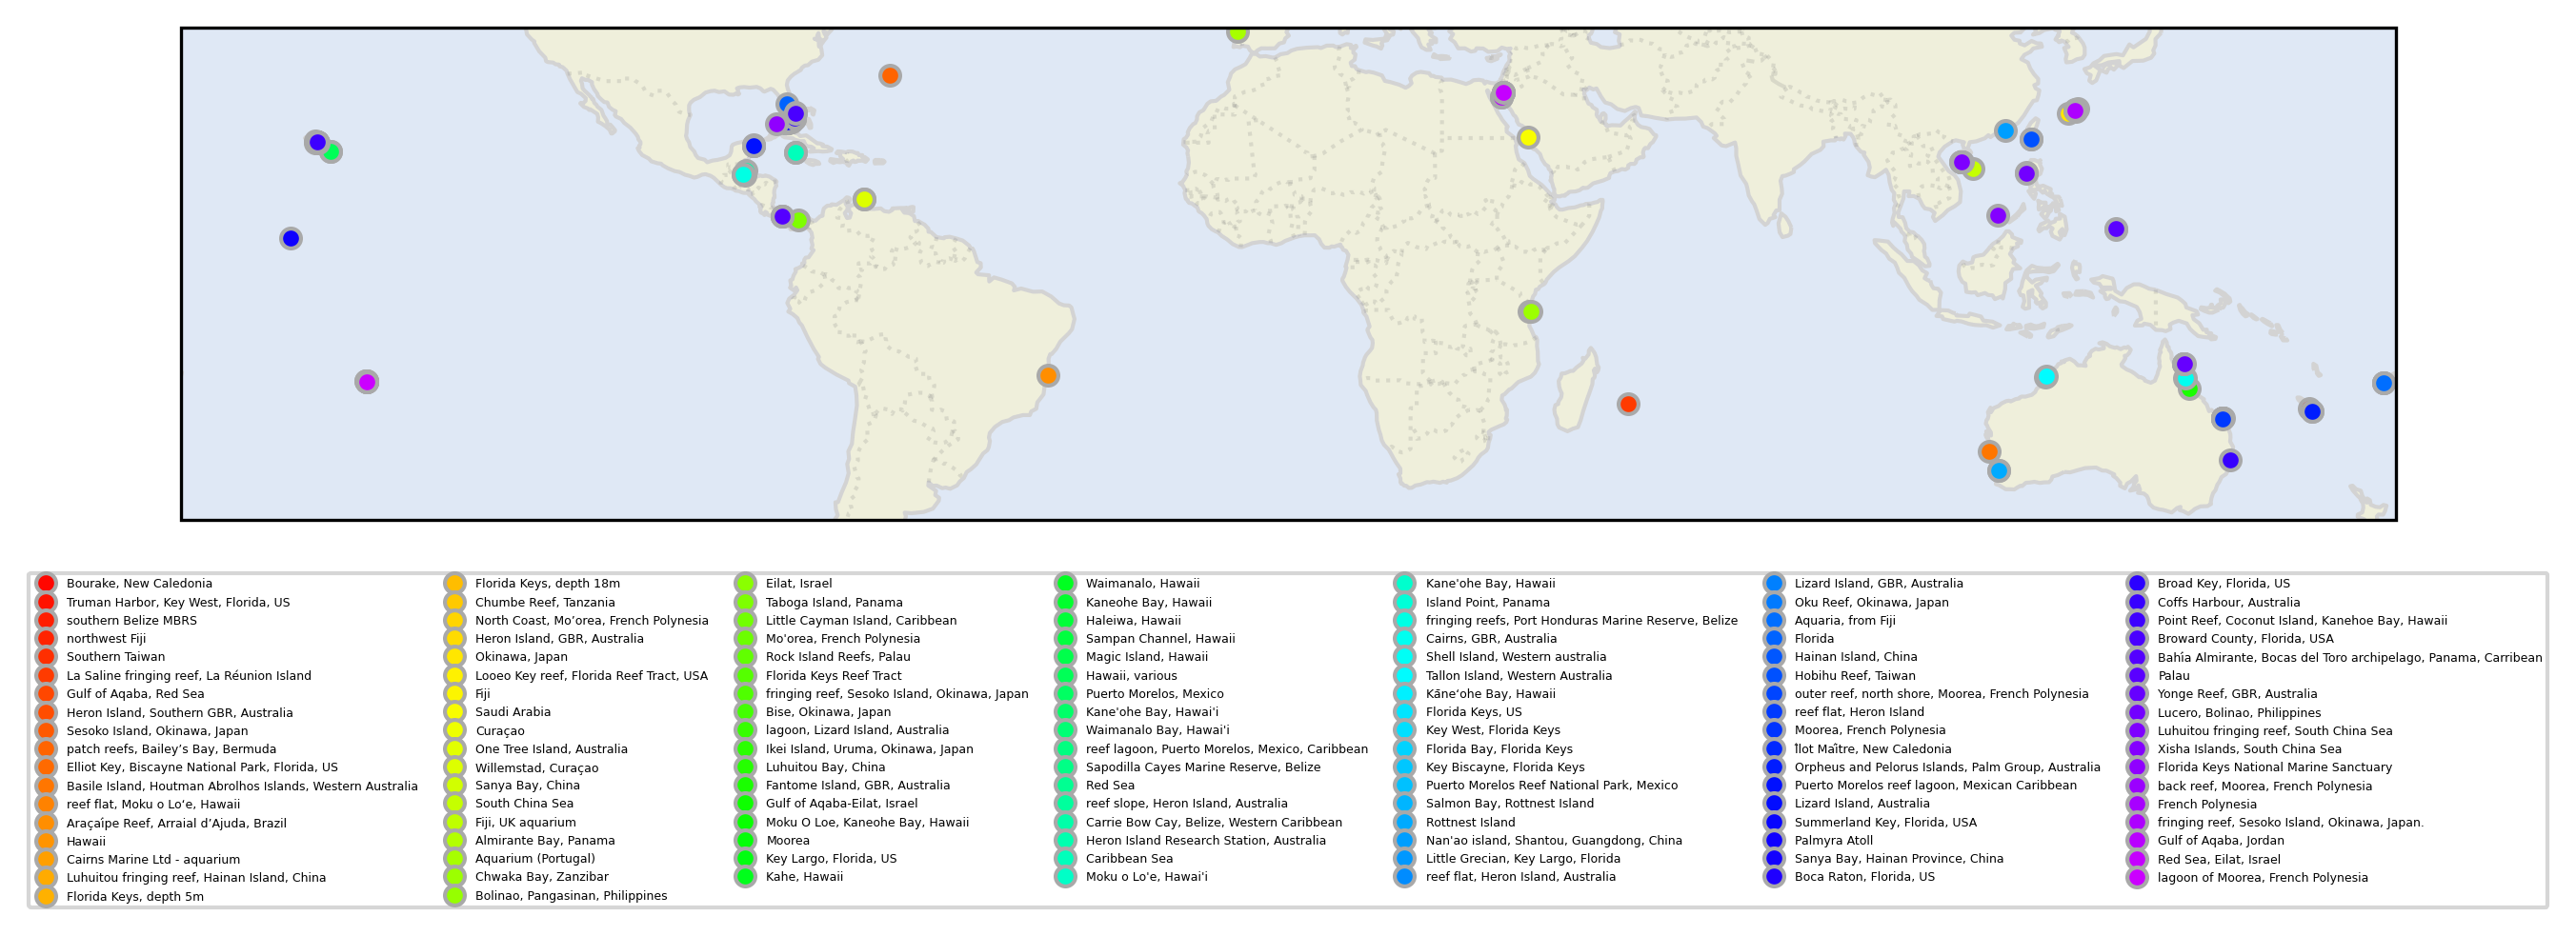

In [8]:
### plot spatial disribution of studies

locs = utils.read_yaml(config.resources_dir / "locations.yaml")   # read locations.yaml
locs_df = pd.DataFrame(locs).T
locs_df = locs_df.dropna()  # drop nans

# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())

# add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.2)

# add locations with colors
colors = sns.color_palette("hsv", len(locs_df))
locations_to_plot = locs_df.drop_duplicates('location')
for i, (doi, row) in enumerate(locations_to_plot.iterrows()):
    data = locs[doi]
    ax.plot(data["longitude"], data["latitude"], 'o', markeredgecolor='darkgrey', markersize=5, color=colors[i], transform=ccrs.PlateCarree(), label=data["location"])

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.8), ncol=len(locs_df)//20, fontsize=3);   # add legend

## Applying reef areas

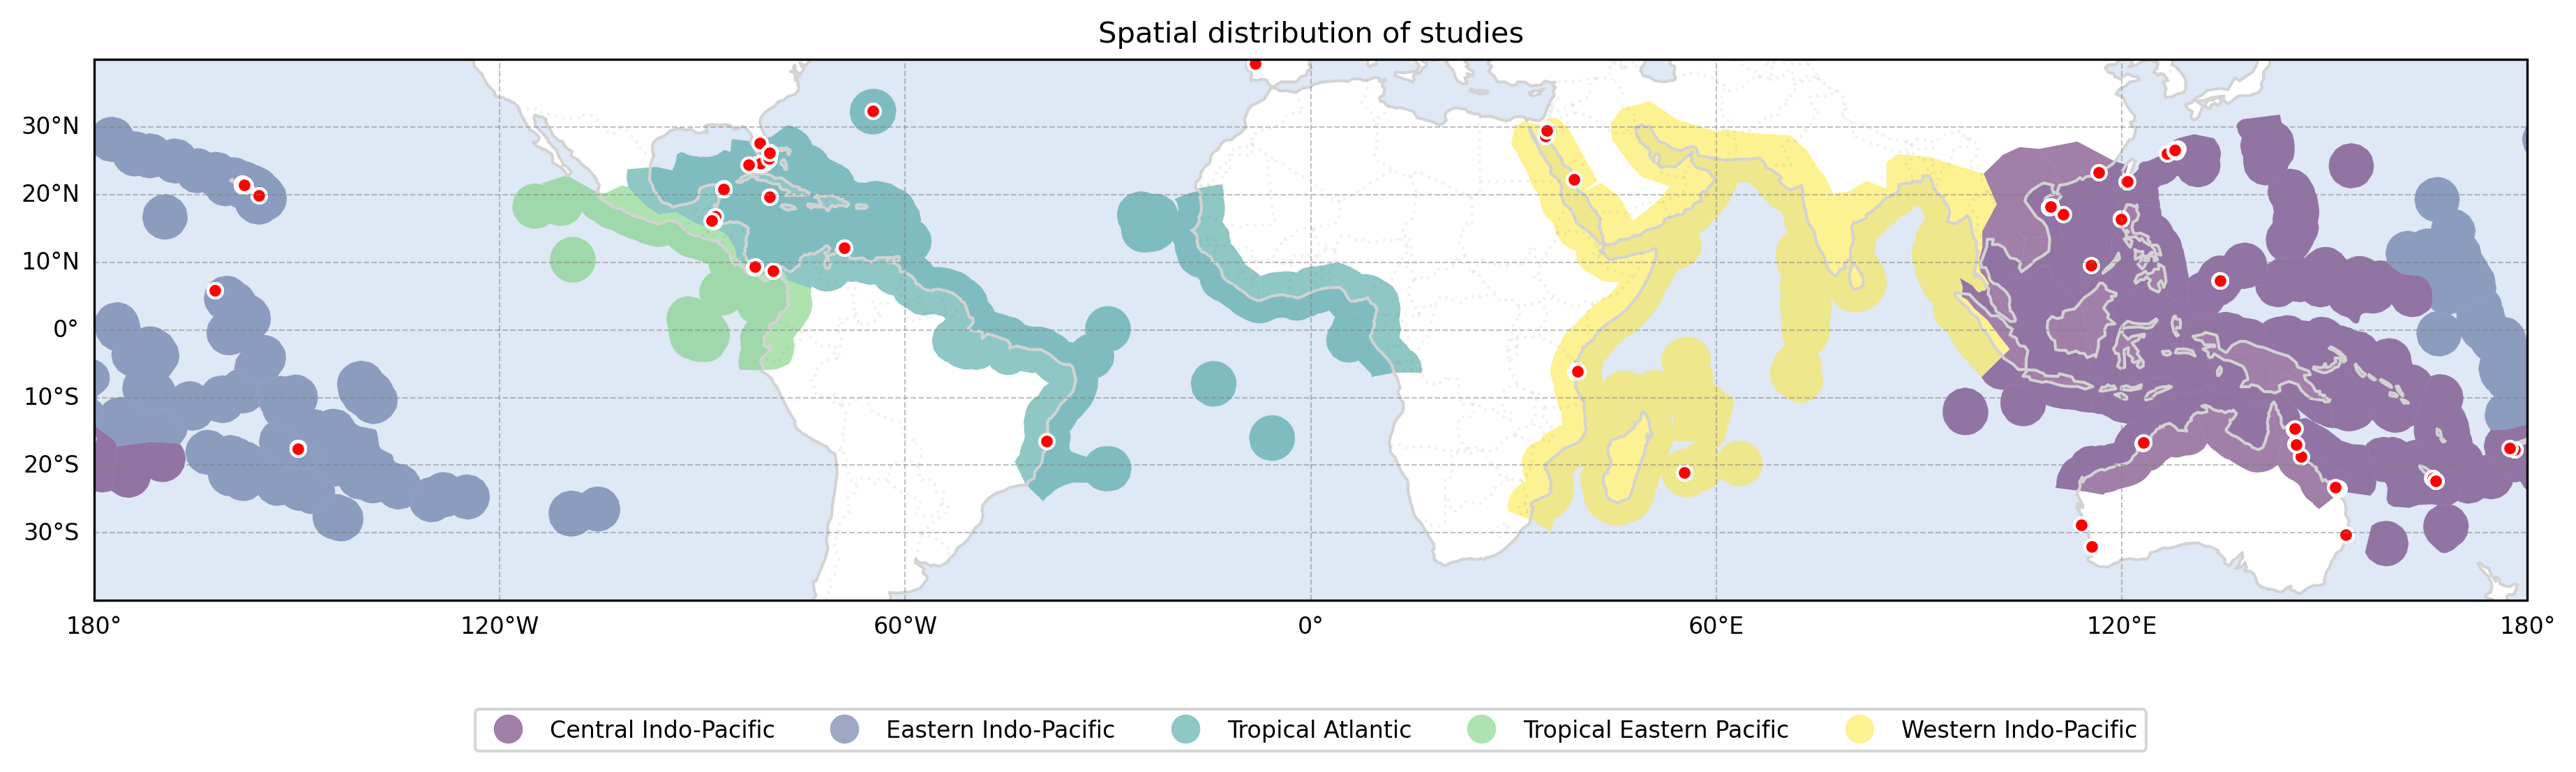

In [9]:
import geopandas as gpd
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import json

# marine area shapefiles dir
shp_dir_fp = config.climatology_data_dir / "MEOW"

# read in shapefiles from directory
gdf = gpd.read_file(shp_dir_fp / "meow_ecos.shp")
tropical_areas_df = gdf[gdf['Lat_Zone'] == 'Tropical']

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())
# add features
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.1)

# plot tropical areas on world map
tropical_areas_df.plot(ax=ax, column='REALM', legend=True, 
                       cmap='viridis', alpha=0.5, 
                       legend_kwds={'bbox_to_anchor': (0.5, -0.3),
                                    'ncol': tropical_areas_df.REALM.nunique(),
                                    'loc': 'lower center',
                                    'fontsize': 8})

for i, (doi, data) in enumerate(locs_df.iterrows()):
    # Convert coordinates to float if needed
    lat = float(data["latitude"]) if isinstance(data["latitude"], str) else data["latitude"]
    lon = float(data["longitude"]) if isinstance(data["longitude"], str) else data["longitude"]
    
    # Only plot if coordinates are valid
    if pd.notna(lat) and pd.notna(lon):
        ax.plot(lon, lat, 'o', markeredgecolor='white', markersize=5, 
                color='red', transform=ccrs.PlateCarree())

ax.set_title('Spatial distribution of studies', fontsize=10)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
# decrease fontsize of grid labels
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
gl.top_labels = False
gl.right_labels = False

In [10]:
### plot spatial distribution of realms

# compute the centroid of each realm by first projecting to a suitable projected CRS
temp_tropical_areas_df = tropical_areas_df.copy()
# Use an equal-area projection to ensure accurate centroid calculation
temp_tropical_areas_df.loc[:,'geometry_projected'] = temp_tropical_areas_df.geometry.to_crs('ESRI:54034')  # World Cylindrical Equal Area
temp_tropical_areas_df.loc[:,'centroid_projected'] = temp_tropical_areas_df['geometry_projected'].centroid
# Convert centroids back to WGS84 (EPSG:4326) for use with lat/lon
temp_tropical_areas_df.loc[:,'centroid'] = temp_tropical_areas_df['centroid_projected'].to_crs('EPSG:4326')
temp_tropical_areas_df.loc[:,'centroid_lat'] = temp_tropical_areas_df['centroid'].y
temp_tropical_areas_df.loc[:,'centroid_lon'] = temp_tropical_areas_df['centroid'].x
# Drop intermediate columns to keep dataframe clean
centroids_df = temp_tropical_areas_df[['RLM_CODE', 'centroid_lat', 'centroid_lon']]
# tropical_areas_df = tropical_areas_df.drop(columns=['geometry_projected', 'centroid_projected'])
# group by realm code and average the lat/lon to get the centroid of each realm
centroids_df = centroids_df.groupby('RLM_CODE').median()

# add column of realm names to centroids df
centroids_df['realm_name'] = centroids_df.index.map(tropical_areas_df.set_index('RLM_CODE')['REALM'].to_dict())

### get the realm for each location in locs_df based on their coordinates
locs_df['latitude'] = pd.to_numeric(locs_df['latitude'], errors='coerce')
locs_df['longitude'] = pd.to_numeric(locs_df['longitude'], errors='coerce')

# create point geometry object from points
points_geometry = [Point(lon, lat) if pd.notna(lon) and pd.notna(lat) else None 
                   for lon, lat in zip(locs_df['longitude'], locs_df['latitude'])]
points_gdf = gpd.GeoDataFrame(locs_df, geometry=points_geometry, crs='EPSG:4326')
# join on geometry
joined = gpd.sjoin(points_gdf, tropical_areas_df[['REALM', 'geometry']], 
                  how='left', predicate='within')

# assign realm to column in locs_df
locs_df['realm'] = joined['REALM']


In [11]:
locations_to_plot = locs_df.copy()

locations_to_plot.loc[:, 'latitude'] = pd.to_numeric(locations_to_plot['latitude'])
locations_to_plot.loc[:, 'longitude'] = pd.to_numeric(locations_to_plot['longitude'])
locations_to_plot.loc[:, 'hover_text'] = list(locations_to_plot.index)

fig = go.Figure()

# Add a high-resolution base map layer
fig.add_trace(go.Scattergeo(
    lon=[None],
    lat=[None],
    mode='markers',
    marker_opacity=0,
    showlegend=False,
))

# Convert tropical areas to GeoJSON
tropical_geojson = json.loads(tropical_areas_df.to_json())

# Add the tropical areas as choropleth layer
fig.add_trace(go.Choropleth(
    geojson=tropical_geojson,
    locations=tropical_areas_df.index,
    z=tropical_areas_df.RLM_CODE,  # colour by realm code
    colorscale='Viridis',
    marker_opacity=0.4,
    marker_line_width=0.5,
    marker_line_color='white',
    showscale=False,
    hoverinfo='text',
    hovertext=[f"{row.ECOREGION} - {row.REALM}" for _, row in tropical_areas_df.iterrows()],
    name='Tropical Marine Ecoregions'
))

# Group by realm for better legend organization
# Group by realm for better legend organization
realm_colors = {
    'Central Indo-Pacific': '#1f77b4',
    'Eastern Indo-Pacific': '#ff7f0e',
    'Western Indo-Pacific': '#2ca02c',
    'Tropical Atlantic': '#d62728',
    'Tropical Eastern Pacific': '#9467bd'
}

for realm in locations_to_plot['realm'].dropna().unique():
    subset = locations_to_plot[locations_to_plot['realm'] == realm]
    fig.add_trace(go.Scattergeo(
        lon=subset['longitude'],
        lat=subset['latitude'],
        text=subset['location'],
        mode='markers',
        marker=dict(
            size=8, 
            opacity=0.8,
            color=realm_colors.get(realm, 'red'),
            line=dict(width=1, color='white')
        ),
        hovertemplate='<b>%{text}</b><br>DOI: %{customdata}<br>Lat: %{lat:.4f}<br>Lon: %{lon:.4f}<br>Realm: ' + realm,
        customdata=subset.index,
        name=realm
    ))

# Plot locations without realm assignment (if any), or if 'aquari' in location name
no_realm = locations_to_plot[(locations_to_plot['realm'].isna() | locations_to_plot['location'].str.contains('aquari', case=False))]
if len(no_realm) > 0:
    fig.add_trace(go.Scattergeo(
        lon=no_realm['longitude'],
        lat=no_realm['latitude'],
        text=no_realm['location'],
        mode='markers',
        marker=dict(
            size=8, 
            opacity=0.8,
            color='black',
            symbol='x'
        ),
        hovertemplate='<b>%{text}</b><br>DOI: %{customdata}<br>Lat: %{lat:.4f}<br>Lon: %{lon:.4f}<br>Realm: Aquarium species',
        customdata=no_realm.index,
        name='Unknown Realm (aquarium species)'
    ))

# Label realms at their centroids
fig.add_trace(go.Scattergeo(
    lon=centroids_df['centroid_lon'],
    lat=centroids_df['centroid_lat'],
    text=centroids_df['realm_name'],
    mode='text',
    textfont=dict(
        size=14,
        color='#2b2b2b',
        family='Arial Black'
    ),
    textposition='middle center',
    hoverinfo='none',
    showlegend=False  # This removes the legend entry for the labels
))

# Formatting map view with higher-resolution settings
fig.update_geos(
    lataxis_range=[-40, 40],
    lonaxis_range=[-180, 180],
    showland=True,
    landcolor='rgb(240,240,240)',
    showocean=True,
    oceancolor='rgb(230, 250, 255)',
    showcoastlines=True,
    coastlinecolor='rgb(80, 80, 80)',
    coastlinewidth=0.5,
    showframe=True,
    framecolor='gray',
    showcountries=True,
    countrycolor='rgb(150,150,150)',
    countrywidth=0.5,
    showlakes=True,
    lakecolor='rgb(230, 250, 255)',
    showrivers=True,
    rivercolor='rgb(230, 250, 255)',
    resolution=50,
    projection_type='natural earth'
)

fig.update_layout(
    title={
        'text': 'Spatial Distribution of Studies in Tropical Marine Ecoregions',
        'font': {'size': 20, 'family': 'Arial'},
        'x': 0.5,
        'y': 0.95
    },
    margin=dict(l=0, r=0, t=60, b=0),
    height=700,
    width=1500,
    legend=dict(
        x=0.01,
        y=0.01,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    ),
    geo=dict(
        bgcolor='rgba(255,255,255,0)'
    ),
    template='plotly_white',
    showlegend=True
)

fig.show()

- Outliers fine to include – but require species which are also present in the tropics
- Informs regions for which there is no data (shade regions by studies conducted)

# Climatology

In [330]:
sst_df = pd.read_csv(config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv").drop(columns=['data_ID', 'Unnamed: 0']).set_index('doi')
sst_df.head()

,location,scenario,time_frame,mean_historical_sst_30y_ensemble,percentile_90_historical_sst_30y_ensemble,percentile_10_historical_sst_30y_ensemble,mean_sst_20y_ensemble,percentile_90_mean_ensemble,percentile_10_mean_ensemble,mean_sst_20y_anomaly_ensemble,percentile_90_anomaly_ensemble,percentile_10_anomaly_ensemble
doi,,,,,,,,,,,,
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp126,2021_2040,24.836919,25.792108,24.021713,25.479635,26.335072,24.656931,0.624418,0.824634,0.480447
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp126,2041_2060,24.836919,25.792108,24.021713,25.686582,26.404444,24.877063,0.831365,1.166733,0.526115
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp126,2081_2100,24.836919,25.792108,24.021713,25.793583,26.692748,24.944811,0.938365,1.279344,0.528275
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp245,2021_2040,24.836919,25.792108,24.021713,25.463312,26.203350,24.545612,0.612489,0.800743,0.415347
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp245,2041_2060,24.836919,25.792108,24.021713,25.914964,26.766372,25.030465,1.064142,1.398613,0.857737


In [225]:
# replace table text of '2021_2040' to 2040
sst_df.replace(
    {"2021_2040": 2040,
     "2041_2060": 2060,
     "2081_2100": 2100},
    inplace=True
)
sst_df = sst_df.infer_objects(copy=False)
# sst_df.reset_index(inplace=True, drop=False)
sst_df.head()

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_93076/2645358079.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,location,scenario,time_frame,mean_historical_sst_30y_ensemble,percentile_90_historical_sst_30y_ensemble,percentile_10_historical_sst_30y_ensemble,mean_sst_20y_ensemble,percentile_90_mean_ensemble,percentile_10_mean_ensemble,mean_sst_20y_anomaly_ensemble,percentile_90_anomaly_ensemble,percentile_10_anomaly_ensemble
doi,,,,,,,,,,,,
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp126,2040,24.836919,25.792108,24.021713,25.479635,26.335072,24.656931,0.624418,0.824634,0.480447
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp126,2060,24.836919,25.792108,24.021713,25.686582,26.404444,24.877063,0.831365,1.166733,0.526115
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp126,2100,24.836919,25.792108,24.021713,25.793583,26.692748,24.944811,0.938365,1.279344,0.528275
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp245,2040,24.836919,25.792108,24.021713,25.463312,26.203350,24.545612,0.612489,0.800743,0.415347
10.1002/ece3.10099-LOC-A,"Bourake, New Caledonia",ssp245,2060,24.836919,25.792108,24.021713,25.914964,26.766372,25.030465,1.064142,1.398613,0.857737


In [ ]:
# merge sst_df with locs_df on index
merged_df

,latitude,longitude,location,scenario,time_frame,mean_historical_sst_30y_ensemble,percentile_90_historical_sst_30y_ensemble,percentile_10_historical_sst_30y_ensemble,mean_sst_20y_ensemble,percentile_90_mean_ensemble,percentile_10_mean_ensemble,mean_sst_20y_anomaly_ensemble,percentile_90_anomaly_ensemble,percentile_10_anomaly_ensemble
10.1111/jpy.13290,-14.692278,145.459236,"Lizard Island, GBR, Australia",ssp126,2040,26.463716,27.420859,25.750633,27.147354,27.976134,26.353228,0.663930,0.891974,0.496686
10.1111/jpy.13290,-14.692278,145.459236,"Lizard Island, GBR, Australia",ssp126,2060,26.463716,27.420859,25.750633,27.354340,28.135895,26.549769,0.870915,1.167103,0.585016
10.1111/jpy.13290,-14.692278,145.459236,"Lizard Island, GBR, Australia",ssp126,2100,26.463716,27.420859,25.750633,27.468302,28.250340,26.683780,0.984877,1.276761,0.647283
10.1111/jpy.13290,-14.692278,145.459236,"Lizard Island, GBR, Australia",ssp245,2040,26.463716,27.420859,25.750633,27.115799,27.942764,26.475963,0.632640,0.822891,0.432165
10.1111/jpy.13290,-14.692278,145.459236,"Lizard Island, GBR, Australia",ssp245,2060,26.463716,27.420859,25.750633,27.564990,28.435157,26.718085,1.081830,1.371993,0.858564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1038/srep19030,20.850000,-86.916667,"reef lagoon, Puerto Morelos, Mexico, Caribbean",ssp370,2060,27.465510,28.231548,26.729626,28.895626,29.611588,27.958263,1.346868,1.761489,1.061386
10.1038/srep19030,20.850000,-86.916667,"reef lagoon, Puerto Morelos, Mexico, Caribbean",ssp370,2100,27.465510,28.231548,26.729626,30.242400,31.170928,29.117344,2.693642,3.224192,2.182568
10.1038/srep19030,20.850000,-86.916667,"reef lagoon, Puerto Morelos, Mexico, Caribbean",ssp585,2040,27.465510,28.231548,26.729626,28.346937,29.199026,27.736941,0.881427,1.087969,0.616497
10.1038/srep19030,20.850000,-86.916667,"reef lagoon, Puerto Morelos, Mexico, Caribbean",ssp585,2060,27.465510,28.231548,26.729626,29.070058,29.955366,28.213955,1.604548,2.092083,1.192793


In [228]:
locs_df

,location,latitude,longitude
10.1111/jpy.13290,"Lizard Island, GBR, Australia",-14.692278,145.459236
10.1038/s41598-019-40620-8-LOC-A,"Mo'orea, French Polynesia",-17.477919,-149.839667
10.1038/s41598-019-40620-8-LOC-B,"Key Largo, Florida, US",25.020000,-80.490000
10.3354/meps11591,"Boca Raton, Florida, US",26.327000,-80.072167
10.3354/meps09309,Palmyra Atoll,5.888503,-162.078666
...,...,...,...
10.4319/lo.2011.56.4.1200,"reef flat, Heron Island, Australia",-23.269000,151.559000
10.1007/s00338-012-0979-8,"Sesoko Island, Okinawa, Japan",26.636567,127.865856
10.4319/lo.2014.59.5.1468,"fringing reef, Sesoko Island, Okinawa, Japan",26.633333,127.858333
10.3354/meps11655,"Broad Key, Florida, US",25.332000,-80.200000


In [ ]:
# TODO: fix realm
# join sst df with locations df (concatenat columns)
tmp_locs_df = locs_df.reset_index(inplace=False, drop=True)
tmp_locs_df.rename(columns={'index': 'doi'}, inplace=True)
tmp_locs_df

,doi,latitude,location,longitude,realm
0,10.1002/ece3.10099-LOC-A,-21.968602,"Bourake, New Caledonia",165.945530,Central Indo-Pacific
1,10.1002/ece3.10099-LOC-B,-21.951103,"Bourake, New Caledonia",165.990065,Central Indo-Pacific
2,10.1002/lno.10952,24.553210,"Truman Harbor, Key West, Florida, US",-81.795899,Tropical Atlantic
3,10.1002/lno.11863,16.189870,southern Belize MBRS,-88.572760,Tropical Atlantic
4,10.1007/s00227-016-2909-8,-17.713371,northwest Fiji,178.065032,Central Indo-Pacific
...,...,...,...,...,...
143,10.7717/peerj.3749,29.500000,"Red Sea, Eilat, Israel",34.916667,Western Indo-Pacific
144,10.7717/peerj.411-LOC-A,5.886160,Palmyra Atoll,-162.126260,Eastern Indo-Pacific
145,10.7717/peerj.411-LOC-B,5.896510,Palmyra Atoll,-162.128098,Eastern Indo-Pacific
146,10.7717/peerj.5347,21.400000,"Kane'ohe Bay, Hawai'i",-157.800000,Eastern Indo-Pacific


In [242]:
# climatology_df = tmp_locs_df.join(sst_df, on='doi', how='left')
climatology_df = sst_df.merge(locs_df[['latitude', 'longitude']], left_index=True, right_index=True, how='left')
# climatology_df
climatology_df = climatology_df.set_index(['scenario', 'location', 'longitude', 'latitude', 'time_frame']).T
climatology_df

scenario                                                  ssp126             \
location                                  Bourake, New Caledonia              
longitude                                             165.945530              
latitude                                              -21.968602              
time_frame                                                  2040       2060   
mean_historical_sst_30y_ensemble                       24.836919  24.836919   
percentile_90_historical_sst_30y_ensemble              25.792108  25.792108   
percentile_10_historical_sst_30y_ensemble              24.021713  24.021713   
mean_sst_20y_ensemble                                  25.479635  25.686582   
percentile_90_mean_ensemble                            26.335072  26.404444   
percentile_10_mean_ensemble                            24.656931  24.877063   
mean_sst_20y_anomaly_ensemble                           0.624418   0.831365   
percentile_90_anomaly_ensemble                          0.824634   1.166733   
percentile_10_anomaly_ensemble                          0.480447   0.526115   

scenario                                                             ssp245  \
location                                             Bourake, New Caledonia   
longitude                                                        165.945530   
latitude                                                         -21.968602   
time_frame                                      2100                   2040   
mean_historical_sst_30y_ensemble           24.836919              24.836919   
percentile_90_historical_sst_30y_ensemble  25.792108              25.792108   
percentile_10_historical_sst_30y_ensemble  24.021713              24.021713   
mean_sst_20y_ensemble                      25.793583              25.463312   
percentile_90_mean_ensemble                26.692748              26.203350   
percentile_10_mean_ensemble                24.944811              24.545612   
mean_sst_20y_anomaly_ensemble               0.938365               0.612489   
percentile_90_anomaly_ensemble              1.279344               0.800743   
percentile_10_anomaly_ensemble              0.528275               0.415347   

scenario                                                         \
location                                                          
longitude                                                         
latitude                                                          
time_frame                                      2060       2100   
mean_historical_sst_30y_ensemble           24.836919  24.836919   
percentile_90_historical_sst_30y_ensemble  25.792108  25.792108   
percentile_10_historical_sst_30y_ensemble  24.021713  24.021713   
mean_sst_20y_ensemble                      25.914964  26.526747   
percentile_90_mean_ensemble                26.766372  27.451942   
percentile_10_mean_ensemble                25.030465  25.672015   
mean_sst_20y_anomaly_ensemble               1.064142   1.675924   
percentile_90_anomaly_ensemble              1.398613   2.074424   
percentile_10_anomaly_ensemble              0.857737   1.137023   

scenario                                                  ssp370             \
location                                  Bourake, New Caledonia              
longitude                                             165.945530              
latitude                                              -21.968602              
time_frame                                                  2040       2060   
mean_historical_sst_30y_ensemble                       24.836919  24.836919   
percentile_90_historical_sst_30y_ensemble              25.792108  25.792108   
percentile_10_historical_sst_30y_ensemble              24.021713  24.021713   
mean_sst_20y_ensemble                                  25.559212  26.119032   
percentile_90_mean_ensemble                            26.494994  27.075039   
percentile_10_mean_ensemble                            24

In [243]:
# Calculate delta_t and its percentiles for all relevant rows in a concise manner
for baseline, metric in zip(["mean_historical_sst_30y_ensemble", "percentile_90_historical_sst_30y_ensemble", "percentile_10_historical_sst_30y_ensemble"],
    ["mean_sst_20y_ensemble", "percentile_90_mean_ensemble", "percentile_10_mean_ensemble"]):
    climatology_df.loc[f"delta_t_{'_'.join(metric.split('_')[:2])}"] = climatology_df.loc[metric] - climatology_df.loc[baseline]
climatology_df

scenario                                                  ssp126             \
location                                  Bourake, New Caledonia              
longitude                                             165.945530              
latitude                                              -21.968602              
time_frame                                                  2040       2060   
mean_historical_sst_30y_ensemble                       24.836919  24.836919   
percentile_90_historical_sst_30y_ensemble              25.792108  25.792108   
percentile_10_historical_sst_30y_ensemble              24.021713  24.021713   
mean_sst_20y_ensemble                                  25.479635  25.686582   
percentile_90_mean_ensemble                            26.335072  26.404444   
percentile_10_mean_ensemble                            24.656931  24.877063   
mean_sst_20y_anomaly_ensemble                           0.624418   0.831365   
percentile_90_anomaly_ensemble                          0.824634   1.166733   
percentile_10_anomaly_ensemble                          0.480447   0.526115   
delta_t_mean_sst                                        0.642716   0.849663   
delta_t_percentile_90                                   0.542964   0.612335   
delta_t_percentile_10                                   0.635218   0.855350   

scenario                                                             ssp245  \
location                                             Bourake, New Caledonia   
longitude                                                        165.945530   
latitude                                                         -21.968602   
time_frame                                      2100                   2040   
mean_historical_sst_30y_ensemble           24.836919              24.836919   
percentile_90_historical_sst_30y_ensemble  25.792108              25.792108   
percentile_10_historical_sst_30y_ensemble  24.021713              24.021713   
mean_sst_20y_ensemble                      25.793583              25.463312   
percentile_90_mean_ensemble                26.692748              26.203350   
percentile_10_mean_ensemble                24.944811              24.545612   
mean_sst_20y_anomaly_ensemble               0.938365               0.612489   
percentile_90_anomaly_ensemble              1.279344               0.800743   
percentile_10_anomaly_ensemble              0.528275               0.415347   
delta_t_mean_sst                            0.956664               0.626392   
delta_t_percentile_90                       0.900639               0.411241   
delta_t_percentile_10                       0.923098               0.523899   

scenario                                                         \
location                                                          
longitude                                                         
latitude                                                          
time_frame                                      2060       2100   
mean_historical_sst_30y_ensemble           24.836919  24.836919   
percentile_90_historical_sst_30y_ensemble  25.792108  25.792108   
percentile_10_historical_sst_30y_ensemble  24.021713  24.021713   
mean_sst_20y_ensemble                      25.914964  26.526747   
percentile_90_mean_ensemble                26.766372  27.451942   
percentile_10_mean_ensemble                25.030465  25.672015   
mean_sst_20y_anomaly_ensemble               1.064142   1.675924   
percentile_90_anomaly_ensemble              1.398613   2.074424   
percentile_10_anomaly_ensemble              0.857737   1.137023   
delta_t_mean_sst                            1.078045   1.689828   
delta_t_percentile_90                       0.974264   1.659834   
delta_t_percentile_10                       1.008752   1.650302   

scenario                                                  ssp370             \
location                                  Bourake, New Caledonia              
longitude     

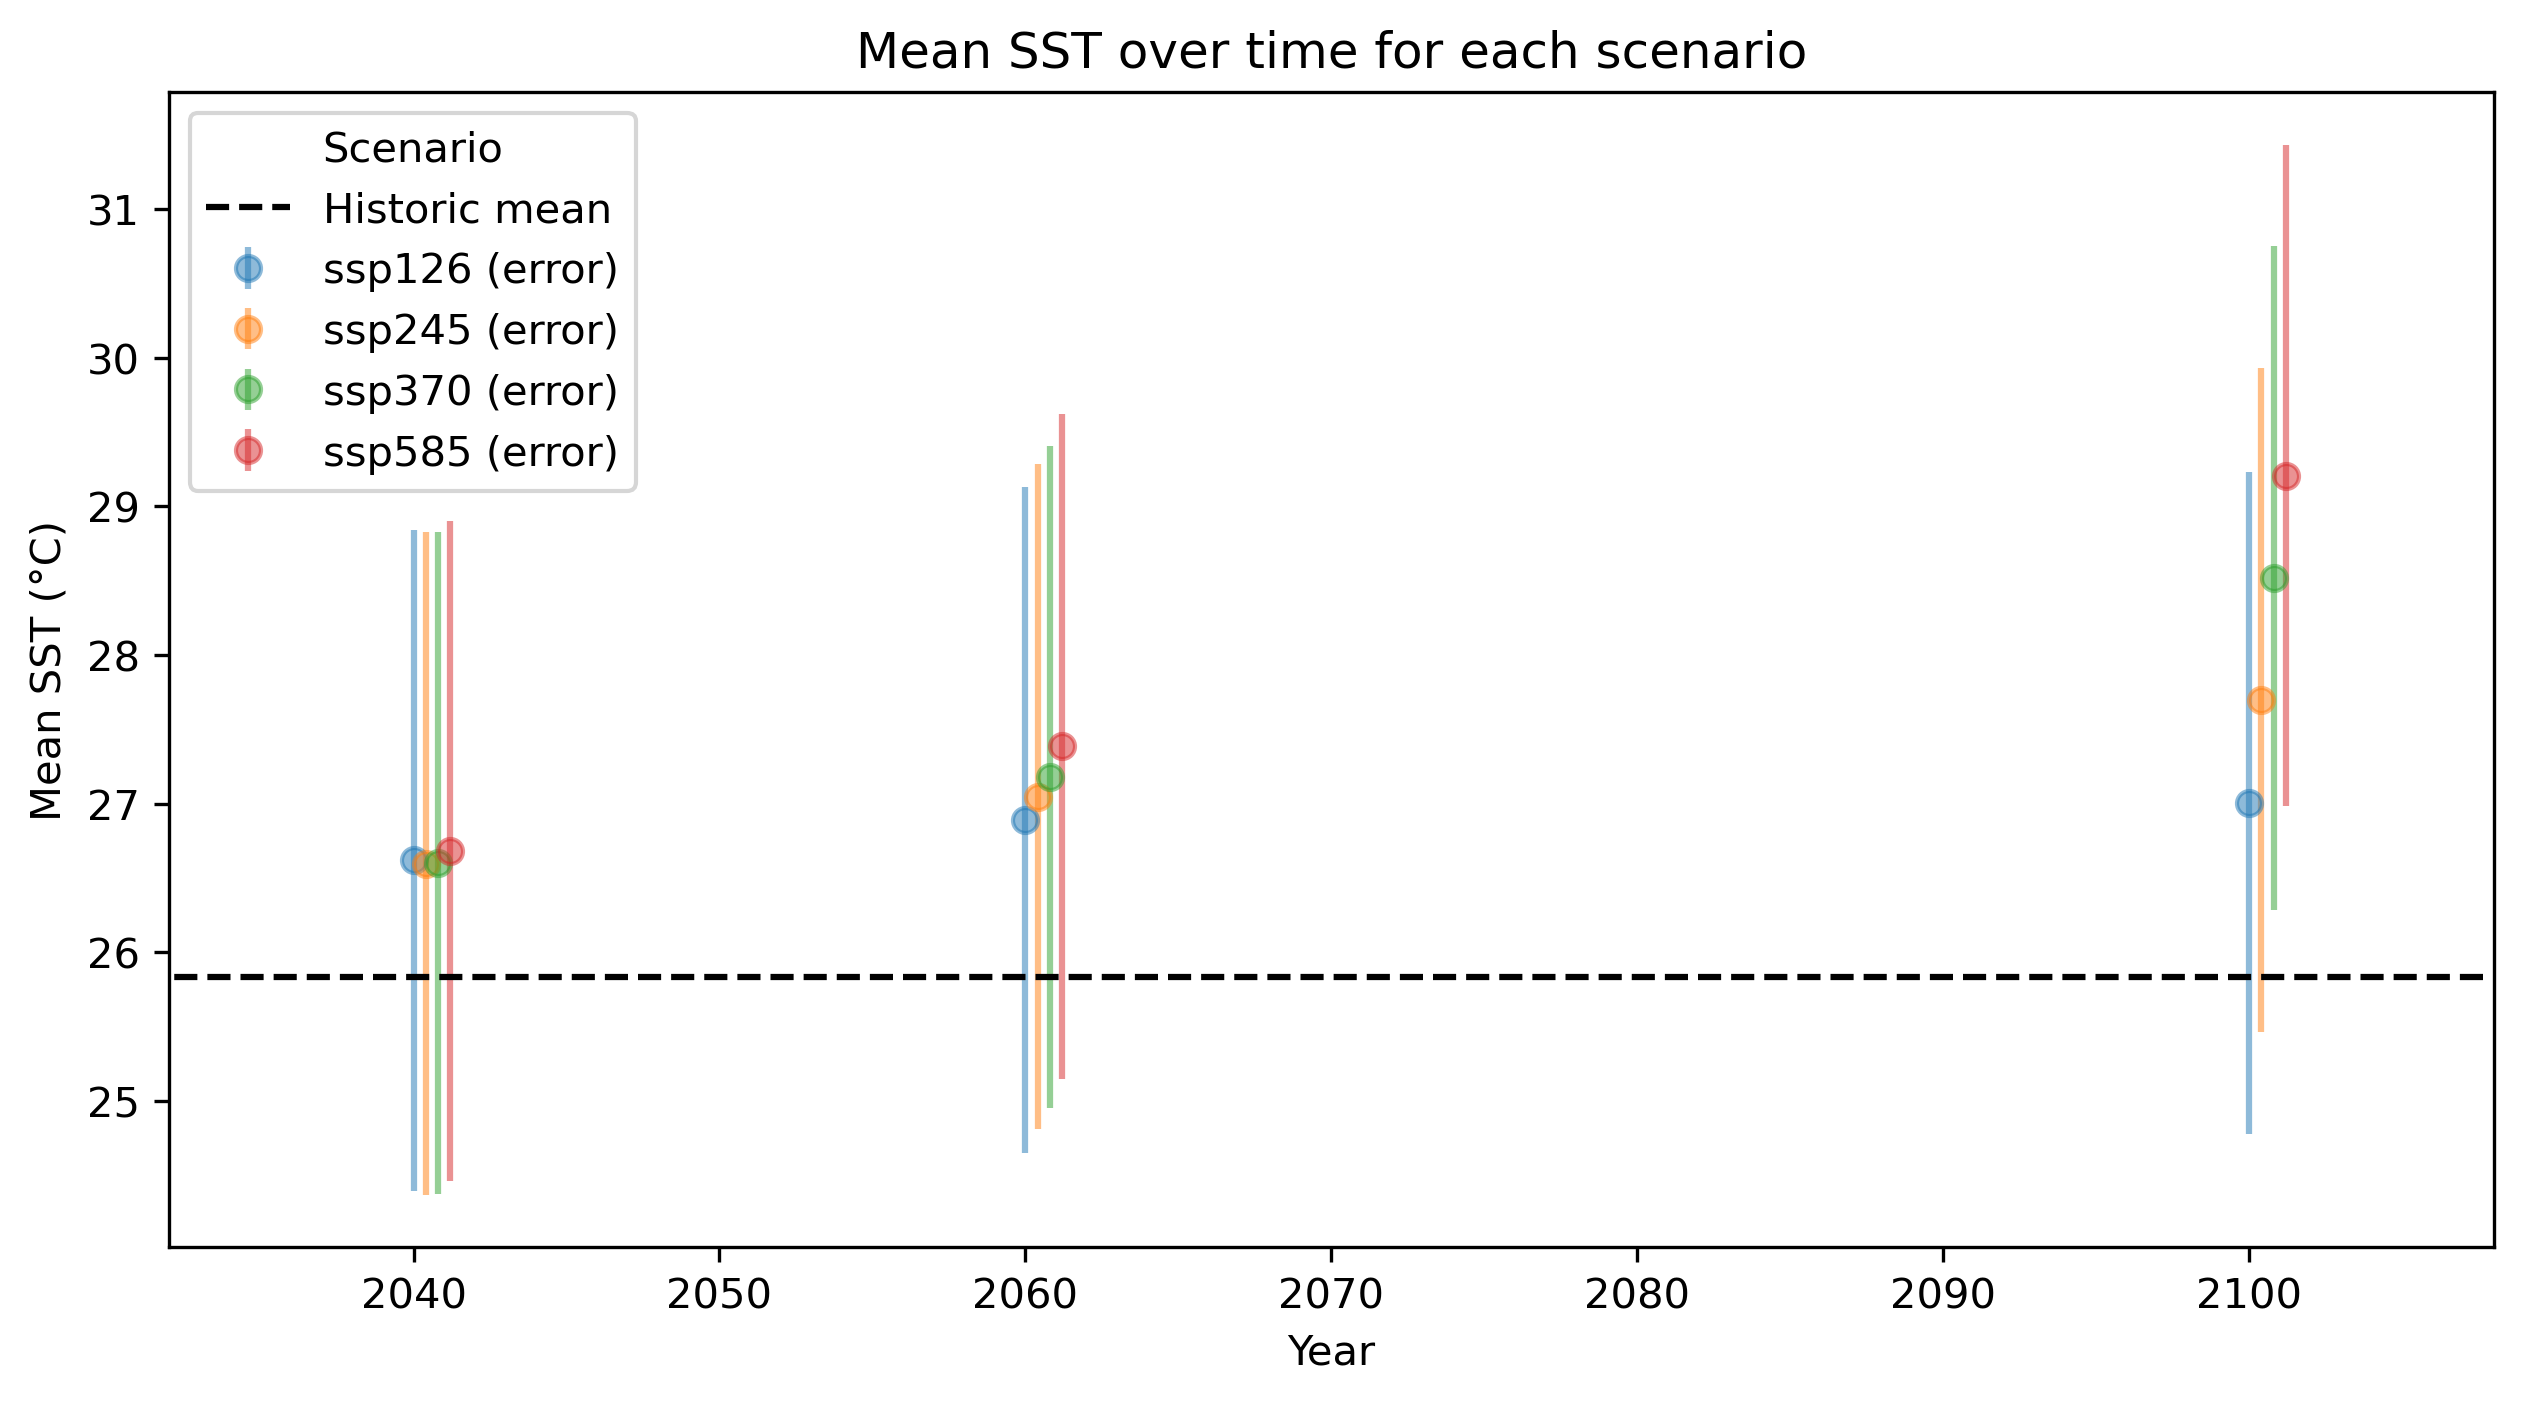

In [244]:
summary_stats = {}
for scenario in climatology_df.columns.get_level_values('scenario').unique():
    summary_stats[scenario] = {}
    scenario_df = climatology_df.loc[:,climatology_df.columns.get_level_values('scenario') == scenario]
    for time_frame in scenario_df.columns.get_level_values('time_frame').unique():
        summary_stats[scenario][time_frame] = {}
        # get the columns for the scenario and time frame
        scenario_df = climatology_df.loc[:,climatology_df.columns.get_level_values('scenario') == scenario]
        scenario_df = scenario_df.loc[:,scenario_df.columns.get_level_values('time_frame') == time_frame]
        mean_sst = scenario_df.loc['mean_sst_20y_ensemble'].mean()
        historic_mean_sst = scenario_df.loc['mean_historical_sst_30y_ensemble'].mean()
        summary_stats[scenario][time_frame]['historic_mean'] = historic_mean_sst
        summary_stats[scenario][time_frame]['mean'] = mean_sst
        summary_stats[scenario][time_frame]['percentile_90'] = scenario_df.loc['percentile_90_mean_ensemble'].mean()
        summary_stats[scenario][time_frame]['percentile_10'] = scenario_df.loc['percentile_10_mean_ensemble'].mean()
        summary_stats[scenario][time_frame]['delta_t'] = scenario_df.loc['delta_t_mean_sst'].mean()
        summary_stats[scenario][time_frame]['sd'] = scenario_df.loc['mean_sst_20y_ensemble'].std()

# plot a scatterplot of how the mean value of each scenario changes over time
summary_stats_df = pd.DataFrame.from_dict(
    {(scenario, time_frame): stats 
     for scenario, time_frames in summary_stats.items() 
     for time_frame, stats in time_frames.items()},
    orient='index'
)
summary_stats_df.index.names = ['Scenario', 'Time Frame']

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
summary_stats_df.reset_index(inplace=True)
summary_stats_df.rename(columns={'Scenario': 'Scenario', 'Time Frame': 'Time Frame'}, inplace=True)
# sns.scatterplot(data=summary_stats_df, x='Time Frame', y='mean', hue='Scenario', ax=ax)
for i, scenario in enumerate(summary_stats_df['Scenario'].unique()):
    scenario_data = summary_stats_df[summary_stats_df['Scenario'] == scenario]
    # Apply a small offset to the x-values for each scenario to avoid overlap
    x_offset = i * 0.4  # Adjust the offset value as needed
    ax.errorbar(scenario_data['Time Frame'] + x_offset, scenario_data['mean'], 
                yerr=scenario_data['sd'], fmt='o', label=f"{scenario} (error)", alpha=0.5)

ax.set_title('Mean SST over time for each scenario')
ax.set_xlabel('Year')
ax.set_ylabel('Mean SST (°C)')
ax.hlines(y=summary_stats_df.historic_mean.iloc[0], xmin=summary_stats_df['Time Frame'].min()-10, xmax=summary_stats_df['Time Frame'].max()+10, color='black', linestyle='--', label='Historic mean')
ax.set_xlim(summary_stats_df['Time Frame'].min()-8, summary_stats_df['Time Frame'].max()+8)
ax.legend(title='Scenario', loc='upper left')

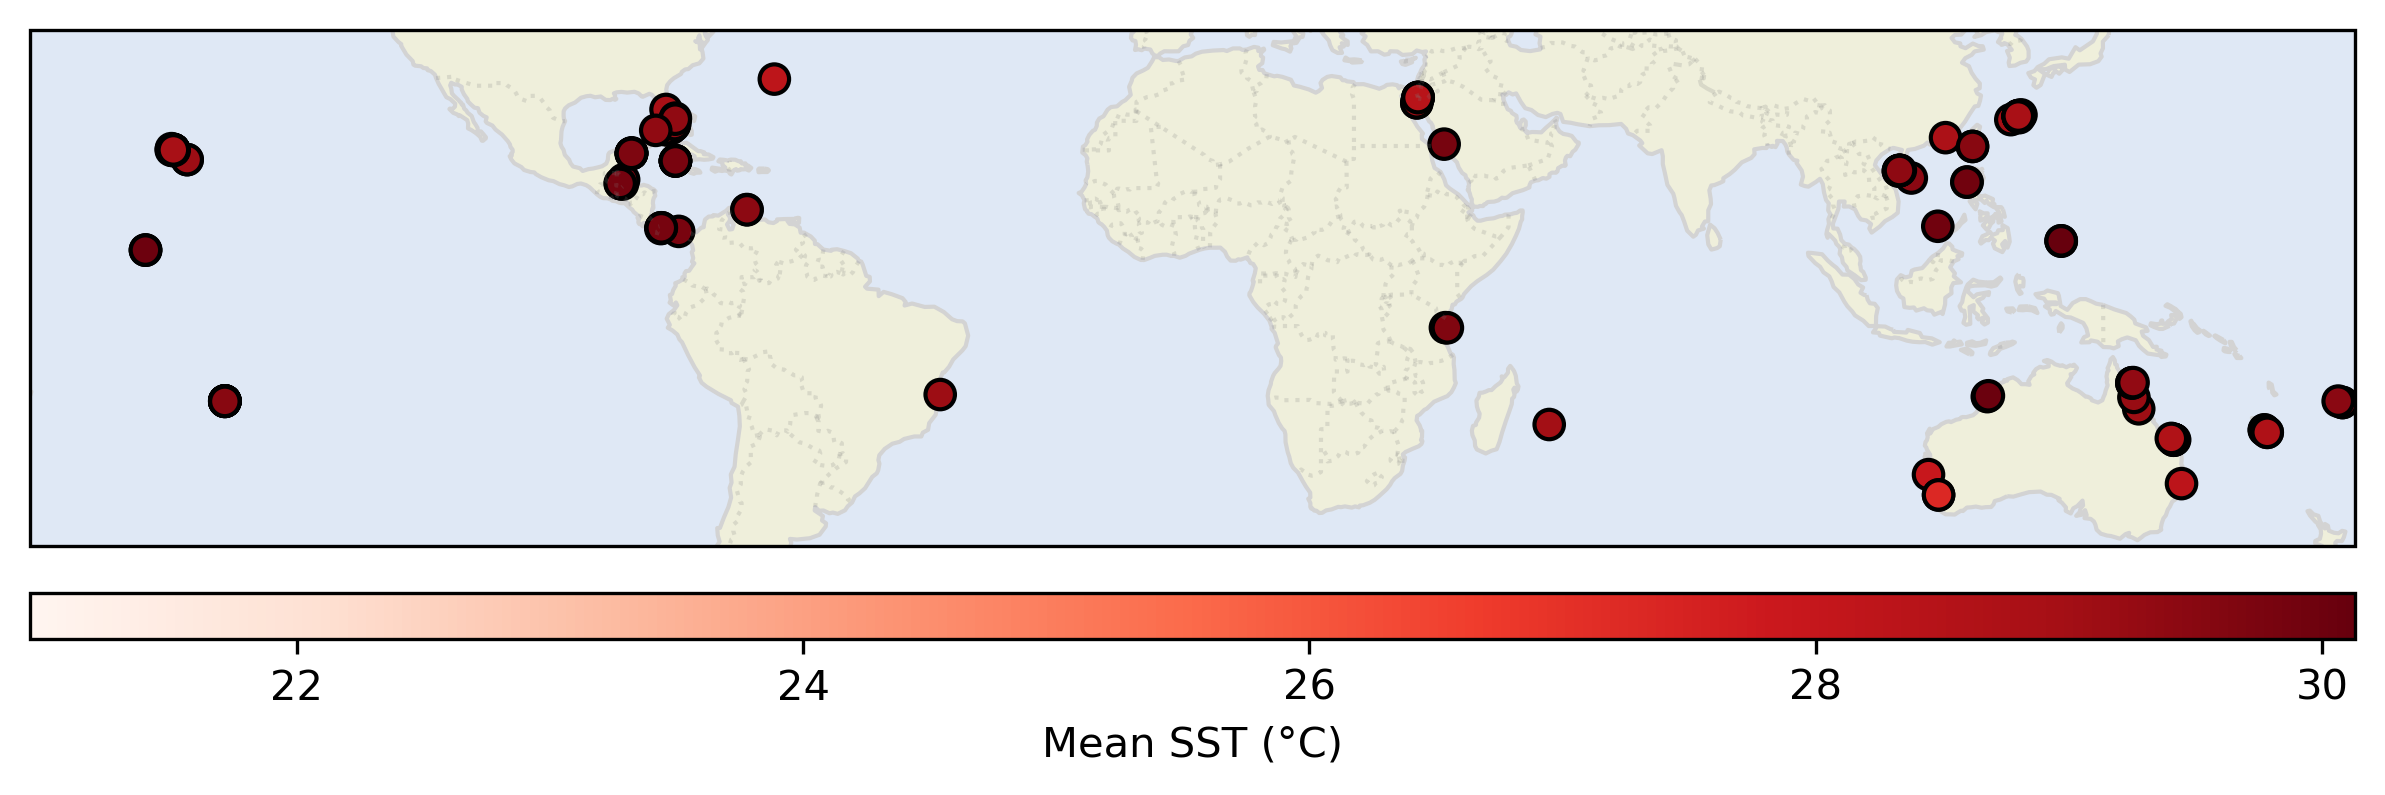

In [329]:
# visualise these changes on the world map with a point for each location
# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())
# add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', zorder=-1)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.2)

scenario = "ssp126"
time_frame = 2100
# select data
data_to_plot = climatology_df.loc[:, ~climatology_df.columns.get_level_values('location').str.contains('aquar', case=False, na=False)]
data_to_plot = data_to_plot.loc['mean_sst_20y_ensemble', scenario].xs(time_frame, level='time_frame').reset_index()

data_to_plot = data_to_plot.dropna(subset=['latitude', 'longitude'])
# colours are based on the mean sst value
colors = sns.color_palette("Reds", as_cmap=True)(data_to_plot['mean_sst_20y_ensemble'] / data_to_plot['mean_sst_20y_ensemble'].max())

sc = ax.scatter(x=data_to_plot['longitude'], y=data_to_plot['latitude'], c=colors, s=50, edgecolor='black', alpha=1, transform=ccrs.PlateCarree(), zorder=1)
# Add colorbar with the same colormap as the scatter plot
norm = plt.Normalize(vmin=data_to_plot['mean_sst_20y_ensemble'].min(), vmax=data_to_plot['mean_sst_20y_ensemble'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Mean SST (°C)', ax=ax, orientation='horizontal', pad=0.01, aspect=50)

In [ ]:
# plot global mean temperature change for each scenario, with error bars

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Set the color palette
colors = sns.color_palette("hsv", len(climatology_df.columns))
# Plot each scenario
for s


# Author locations

In [12]:
# make dictionary of authors and their affiliations

author_list = ['Oscar Branson <ob266@cam.ac.uk>', 'Verena Schoepf <v.schoepf@uva.nl>', 'Steeve Comeau <steeve.comeau@imev-mer.fr>', 'Ben Harvey <ben.harvey@shimoda.tsukuba.ac.jp>', 'Travis A Courtney <travis.courtney@upr.edu>', 'Andreas Andersson <aandersson@ucsd.edu>', 'Ian Enochs <ian.enochs@noaa.gov>', 'Chris Perry <C.Perry@exeter.ac.uk>', 'Alice Webb <A.E.Webb@exeter.ac.uk>', 'Lauren Toth <ltoth@usgs.gov>', 'Simon Donner <simon.donner@ubc.ca>', 'Cheryl Logan <CLogan@csumb.edu>', 'Denisa Berbece <denisa.berbece@vuw.ac.nz>', 'Ashtyn Isaak <ashtyn.isaak@vuw.ac.nz>', 'Holly Koch <holly.koch@vuw.ac.nz>', 'Orlando Timmerman <rt582@cam.ac.uk>']

affiliation_map = {
    'cam': 'Cambridge',
    'uva': 'Amsterdam',
    'imev-mer': 'Sorbonne University',
    'shimoda': 'Shimoda, Japan',
    'upr': 'Puerto Rico',
    'ucsd': 'UC San Diego',
    'exeter': 'Exeter',
    'usgs': 'St. Petersburg, Florida',
    'ubc': 'University of British Columbia',
    'csumb': 'California State University, Monterey Bay',
    'vuw': 'Victoria University of Wellington, New Zealand',
    'noaa': 'NOAA, Miami',
}

affiliations = {}
for author in author_list:
    author_parts = author.split('<')
    name = author_parts[0].strip()
    email = author_parts[1].replace('>', '').strip()
    domain = email.split('@')[1]
    affiliation_key = domain.split('.')[0]
    
    # Initialize the dictionary for each author
    affiliations[name] = {
        'email': email,
        'affiliation': affiliation_map.get(affiliation_key, affiliation_key)
    }

# use google maps api to get coordinates for locations
gmaps_coords = {}
GMAPS_API_KEY = utils.read_yaml(config.resources_dir / "api_keys.yaml")['google_maps_api']
gmaps_client = googlemaps.Client(key=GMAPS_API_KEY)

locs = [affiliations[person]['affiliation'] for person in list(affiliations.keys())]
for loc in tqdm(locs, desc="Querying Google Maps to retrieve coordinates of locations"):
    gmaps_coords[loc] = tuple(locations.get_coordinates_from_gmaps(loc, gmaps_client).values)   # slightly hacky formatting since originally written for processing dataframe column

# add coordinates to affiliations dictionary
for author in affiliations.keys():
    affiliations[author]['coordinates'] = gmaps_coords[affiliations[author]['affiliation']]
affiliations_df = pd.DataFrame(affiliations).T
affiliations_df

Querying Google Maps to retrieve coordinates of locations: 100%|██████████| 16/16 [00:00<00:00, 17.25it/s]


,email,affiliation,coordinates
Oscar Branson,ob266@cam.ac.uk,Cambridge,"(52.1950788, 0.1312729)"
Verena Schoepf,v.schoepf@uva.nl,Amsterdam,"(52.3675734, 4.9041389)"
Steeve Comeau,steeve.comeau@imev-mer.fr,Sorbonne University,"(48.84695, 2.3555697)"
Ben Harvey,ben.harvey@shimoda.tsukuba.ac.jp,"Shimoda, Japan","(34.6796171, 138.9451459)"
Travis A Courtney,travis.courtney@upr.edu,Puerto Rico,"(18.220833, -66.590149)"
Andreas Andersson,aandersson@ucsd.edu,UC San Diego,"(32.881168, -117.2343605)"
Ian Enochs,ian.enochs@noaa.gov,"NOAA, Miami","(25.7616798, -80.1917902)"
Chris Perry,C.Perry@exeter.ac.uk,Exeter,"(50.72603669999999, -3.5274889)"
Alice Webb,A.E.Webb@exeter.ac.uk,Exeter,"(50.72603669999999, -3.5274889)"
Lauren Toth,ltoth@usgs.gov,"St. Petersburg, Florida","(27.7671271, -82.6384451)"


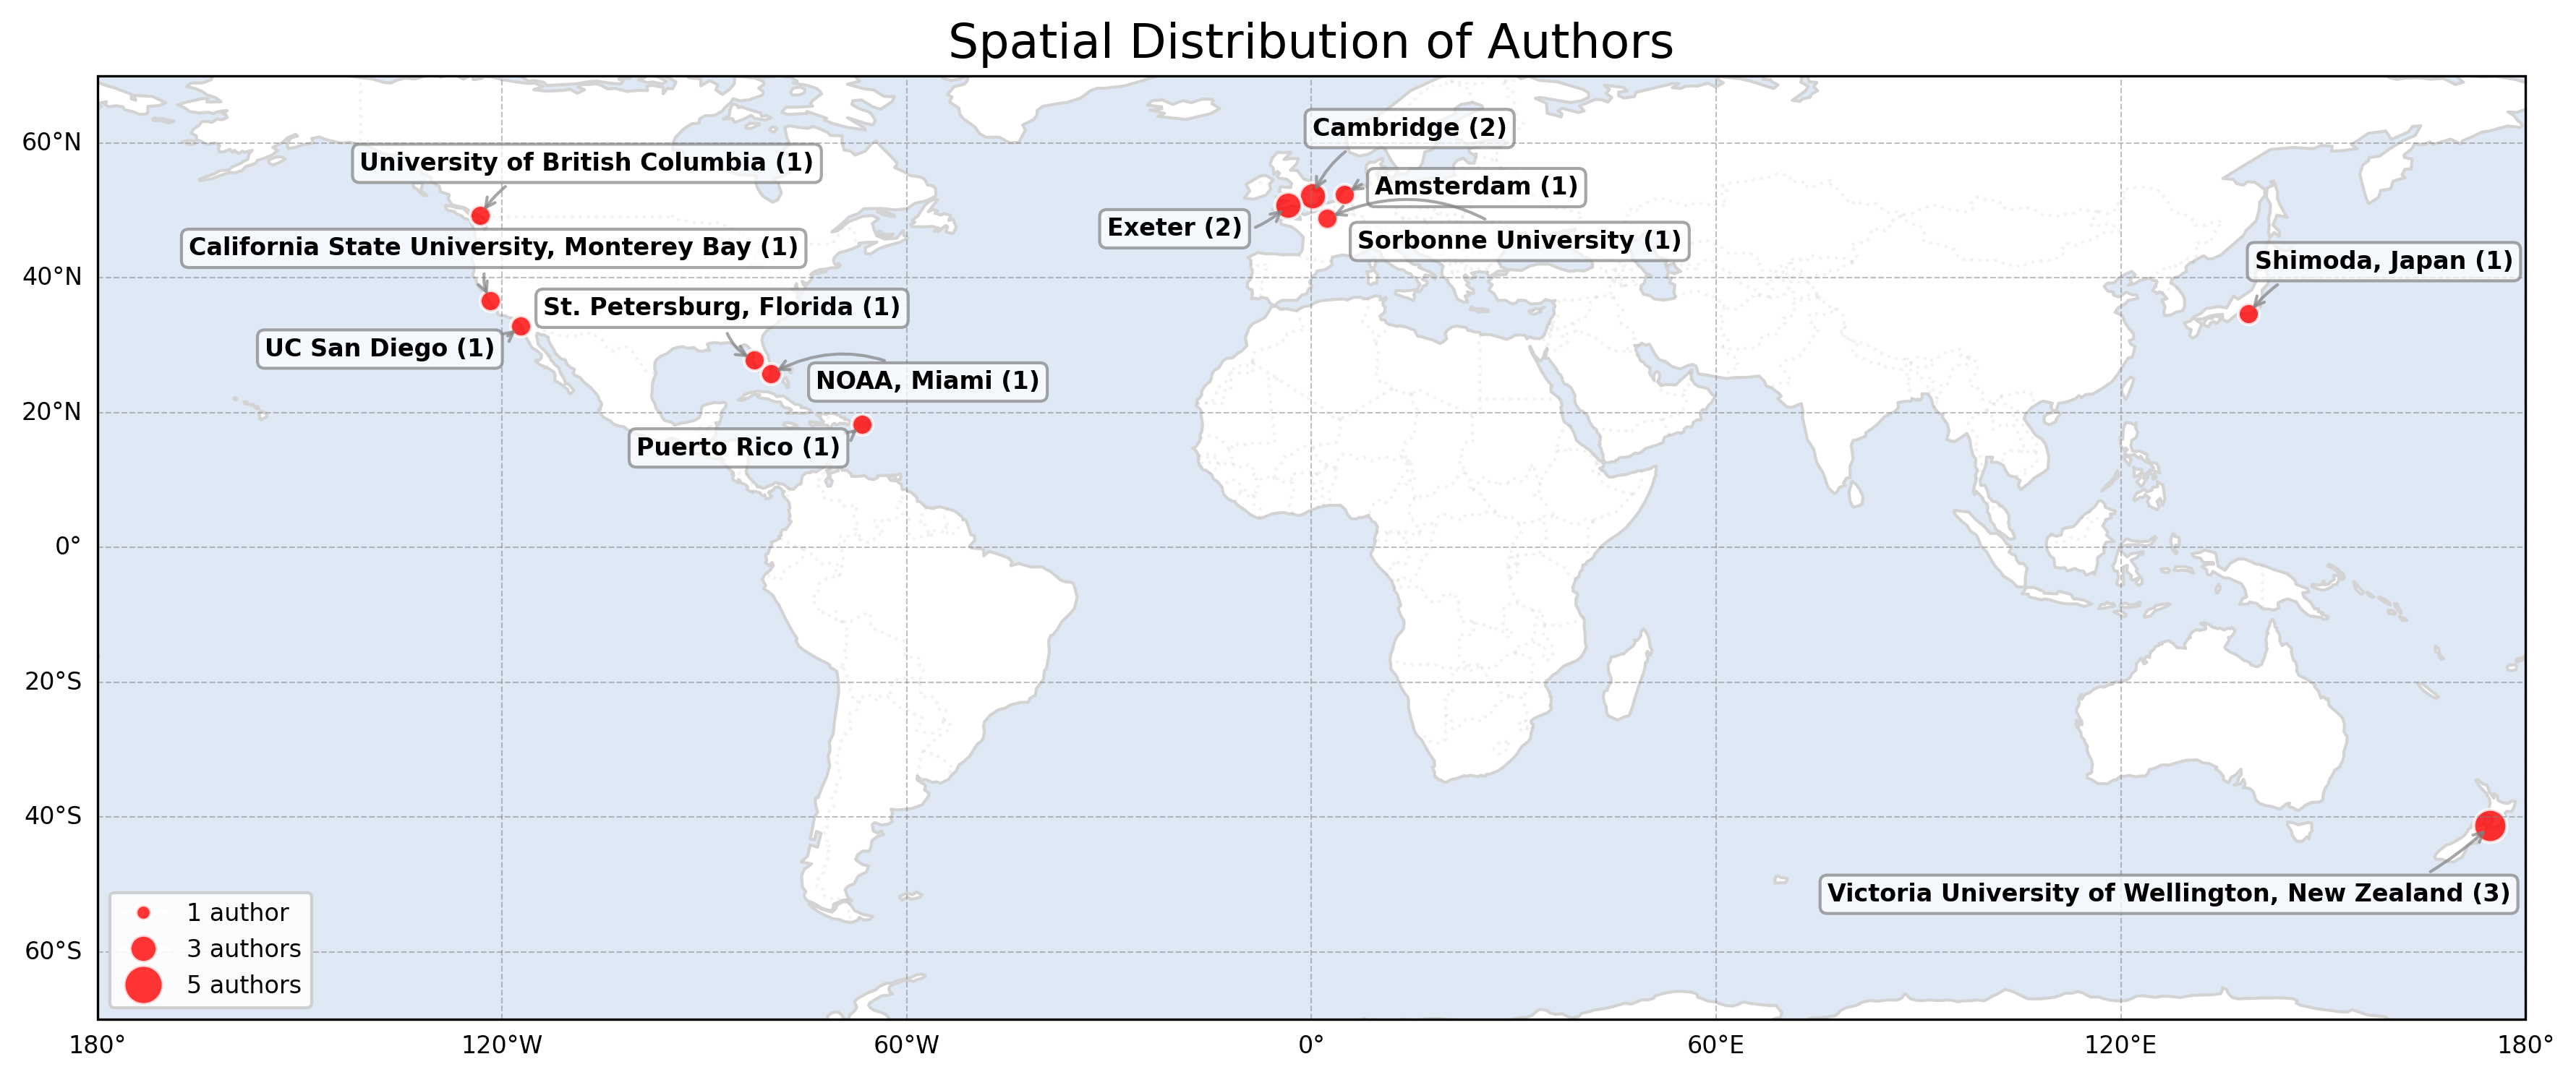

In [13]:
### plot on worldmap with annotations and improved visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

# add features
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.1)

# Count number of authors at each location to size markers accordingly
location_count = {}
for i, data in affiliations_df.iterrows():
    loc = data['coordinates']
    if loc in location_count:
        location_count[loc] += 1
    else:
        location_count[loc] = 1

# Define offsets to prevent label overlapping
# We'll use different offsets for different regions to avoid overlapping
offsets = {
    # Format: coordinates: (x_offset, y_offset)
    (52.1950788, 0.1312729): (0, 20),  # Cambridge
    (52.3675734, 4.9041389): (10, 0),  # Amsterdam
    (50.72603669999999, -3.5274889): (-60, -10),  # Exeter
    (48.84695, 2.3555697): (10, -10),  # Sorbonne
    (38.0335529, -78.5079772): (5, -15),  # UVA
    (34.6796171, 138.9451459): (2, 15),  # Shimoda
    (18.220833, -66.590149): (-75, -10),  # Puerto Rico
    (32.881168, -117.2343605): (-85, -10),  # UC San Diego
    (25.7616798, -80.1917902): (15, -5),  # NOAA Miami
    (27.7671271, -82.6384451): (-70, 15),  # St. Petersburg
    (49.26060520000001, -123.2459939): (-40, 15),  # UBC
    (36.653712, -121.7989787): (-100, 15),  # CSUMB
    (-41.2923814, 174.7787463): (-220, -25),  # Victoria University
}

# Plot each location once with size based on number of authors
plotted_locations = set()
for i, (index, data) in enumerate(affiliations_df.iterrows()):
    loc = data['coordinates']
    if loc not in plotted_locations and pd.notna(loc[0]) and pd.notna(loc[1]):
        # Size based on number of authors at this location
        size = 5 + location_count[loc] * 2
        
        # Plot marker with size based on number of authors
        ax.plot(loc[1], loc[0], 'o', markeredgecolor='white', markersize=size, 
                color='red', transform=ccrs.PlateCarree(), alpha=0.8)
        
        # Get all authors at this location for annotation
        authors_at_loc = [idx for idx, row in affiliations_df.iterrows() 
                         if row['coordinates'] == loc]
        author_count = len(authors_at_loc)
        
        # Get offset for this location, default if not specified
        x_offset, y_offset = offsets.get(loc, (5, 5))
        
        # Shorten affiliation text if it's too long
        affiliation_text = data['affiliation']
        # if len(affiliation_text) > 30:
            # affiliation_text = affiliation_text[:27] + "..."
            
        # Annotate with location name and author count
        ax.annotate(f"{affiliation_text} ({author_count})",
                    xy=(loc[1], loc[0]), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                    xytext=(x_offset, y_offset), textcoords='offset points',
                    fontsize=8, color='black', weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", 
                                   color='gray', alpha=0.7))
        
        plotted_locations.add(loc)

ax.set_title('Spatial Distribution of Authors', fontsize=16)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
gl.top_labels = False
gl.right_labels = False

# Add legend for the marker size
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=5, label='1 author', alpha=0.8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=9, label='3 authors', alpha=0.8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=13, label='5 authors', alpha=0.8)
]
ax.legend(handles=legend_elements, loc='lower left', frameon=True, 
          framealpha=0.9, fontsize=8)

plt.tight_layout()